# Package, Set up & Access

In [1]:



import os
from google.colab import drive 
import numpy as np
import pandas as pd
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import operator
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import string
import re

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=43518ad925f3e7f82c9b7f7cf3a8f11453642ac6474117a5be2b28d4649c7705
  Stored in directory: /tmp/pip-ephem-wheel-cache-bggw8wp3/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
# Read Data
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")

In [5]:
# Check for nonNaN data count
np.array(df.notna().sum())
df.head

<bound method NDFrame.head of        u_affected_application   sys_created_on  ... Unnamed: 18  1
0            Cisco AnyConnect  1/31/2021 23:56  ...         NaN  2
1                      Driver  1/31/2021 23:54  ...         NaN  3
2            Cisco AnyConnect  1/31/2021 23:53  ...         NaN  4
3            Cisco AnyConnect  1/31/2021 23:48  ...         NaN  5
4                         NaN  1/31/2021 23:42  ...         NaN  6
...                       ...              ...  ...         ... ..
141027              undefined    1/1/2020 1:22  ...         NaN  0
141028              undefined    1/1/2020 1:18  ...         NaN  1
141029              undefined    1/1/2020 1:06  ...         NaN  2
141030                    NaN    1/1/2020 0:28  ...         NaN  3
141031              undefined    1/1/2020 0:01  ...         NaN  4

[141032 rows x 20 columns]>

# Data Visualization / Bivariate Visualization

In [ ]:
# Upon studying the variables, categorize them (partial) into lists .





category_variables_2 = [ 'UCiClassName', 'Subcategory', 'UDepartment']
time_variables = ['BusinessDuration','CalendarDuration']
quantitative_variables = ['ReassignmentCount','ReopenCount']
text_variables = ['ShortDescription','CommentsAndWorkNotes','WorkNotes','Description','CloseNotes','Comments']   
relational_variable = ['ClosedBy','FollowUp','ParentIncident','ReopenedBy', 'UCustomer', 'ResolvedBy', 'ChildIncidents']     

## Categorical Variables Class Distribution

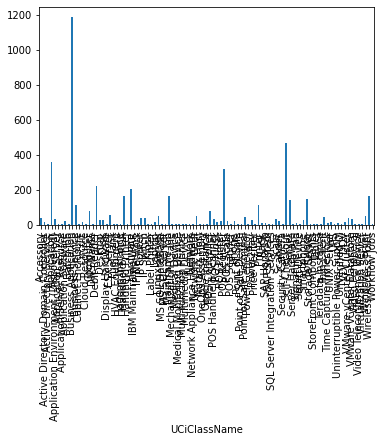

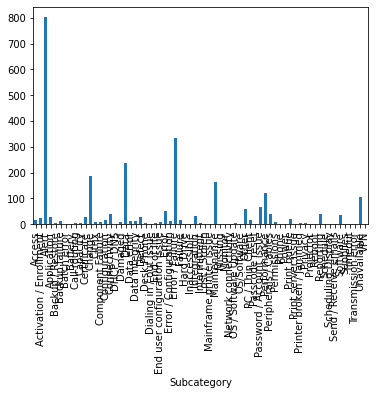

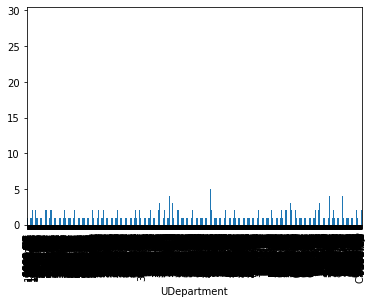

In [ ]:
import matplotlib.pyplot as plt

df['for_count'] = 1
for c in category_variables_2:
  plt.figure()
  df.groupby(c).count().loc[:,'for_count'].plot(kind='bar')
plt.show()

## Quantitatives Variables Data Distribution

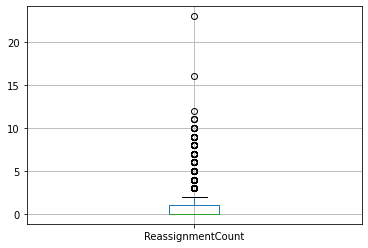

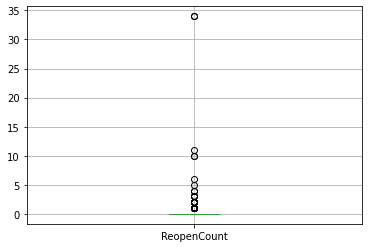

In [ ]:
for q in quantitative_variables:
  plt.figure()
  df.boxplot(column=q)
plt.show()

## Total Incident Distribution over Time

Text(0.5, 1.0, 'Count of Claim Per Day')

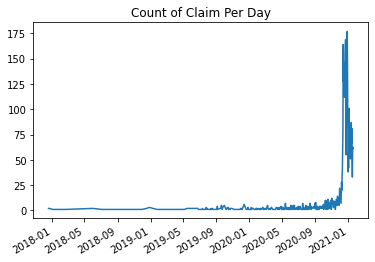

In [ ]:
df['OpenedAt'] = pd.to_datetime(df['OpenedAt'])
df['OpenedAt'].dt.floor('d').value_counts().sort_index().plot()
plt.title(label='Count of Claim Per Day')

### Incident Distribution By Hour

In [ ]:
df['hour'] = df['OpenedAt'].apply(lambda x: x.hour)
temp = df.groupby(by='hour')['OpenedAt'].count().reset_index()
fig = px.line(temp, x="hour", y="OpenedAt")
fig.show()

### Incident Distribution by Day of Week

In [ ]:
df['day_of_week'] = df['OpenedAt'].apply(lambda x: x.dayofweek) + 1
temp = df.groupby(by='day_of_week')['OpenedAt'].count().reset_index()
fig = px.line(temp, x="day_of_week", y="OpenedAt")
fig.show()

### Incident Distribution By Hour & By Other Categories



In [ ]:
for c in category_variables_2:
  temp = df.groupby(['hour',c])['OpenedAt'].count().reset_index()
  fig = px.line(temp, x="hour", y="OpenedAt", color=c,labels={'OpenedAt':"{} Count".format(c)})
  fig.show()

KeyboardInterrupt: ignored

### Incident Distribution By DayofWeek & & By Other Categories



In [ ]:
for c in category_variables:
  temp = df.groupby(['day_of_week',c])['OpenedAt'].count().reset_index()
  fig = px.line(temp, x="day_of_week", y="OpenedAt", color=c, labels={'OpenedAt':"{} Count".format(c)})
  fig.show()

### Resolved Incident Rate

In [ ]:
for c in category_variables:
  temp = df.groupby([c,'State'])['State'].count().unstack()
  temp_total = temp.sum(axis=1)
  temp['Resolved Rate'] = temp['Resolved']/temp_total
  temp.reset_index(inplace=True)
  fig = px.scatter(temp, x=c, y='Resolved Rate')
  fig.show()

In [ ]:
len(df['State'][df['State']=='Assigned'])/len(df)

0.121632488942501

# Text Analytic 


In [ ]:
def costum_tokenize(text):
  try:
    text = re.sub('\W+',' ', text)
    text = word_tokenize(text)
  except TypeError:
    text = 'NaN'
  
  return ' '.join(text)

def freq_count(col):
  frq_dic = {}
  for lst in col:
    for i in lst:
      if i not in stop_words and i.isalpha():
        if i in frq_dic:
          frq_dic[i] += 1
        else:
          frq_dic[i] = 1
  return frq_dic

def split1(text):
  try:
    t = text[:19]
    return t
  except TypeError:
    return None

def split2(text):
  try:
    text = text[19:]
    return text
  except TypeError:
    return None

def clean_review(review):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))   
    return review.translate(replace_punctuation).lower()

def remodel (text):
  return ' '.join(word_tokenize(clean_review(text)))
  

### Cleaning

In [ ]:
df2 = df[['u_ci_class_name', 'short_description','category','description']].dropna()
#df2['Combined'] = df2['CommentsAndWorkNotes'].astype(str)+df2['ShortDescription'].astype(str)
df2['Combined'] = df2['short_description'].astype(str) + df2['description'].astype(str)
df2['TimeStamp'] = df2['Combined'].apply(split1)
df2['Combined'] = df2['Combined'].apply(split2)
df2['cleaned_CAW'] = df2['Combined'].apply(costum_tokenize)

X = df2['cleaned_CAW']
y = df2['category']

df2.head()


,u_ci_class_name,short_description,category,description,Combined,TimeStamp,cleaned_CAW
1,Active Directory Service,Facing access issue while querying tables in D...,Access,What are you reporting for: Home Office\nWho i...,while querying tables in Data discoveryWhat a...,Facing access issue,while querying tables in Data discoveryWhat ar...
4,VDI / DDV,HO: VDI - Login Issues - Desktop is Unavailable,VDI,Impacted User ID- vn51cpm\r\n\tIssue descripti...,ues - Desktop is UnavailableImpacted User ID- ...,HO: VDI - Login Iss,ues Desktop is UnavailableImpacted User ID vn5...
5,Business Application,Customers are not receiving email,Network,What are you reporting for: Store / Club\nWho ...,eceiving emailWhat are you reporting for: Stor...,Customers are not r,eceiving emailWhat are you reporting for Store...
6,Business Application,Unable to receive faxes,Telephony,FixIT Options:---Phones - Pharmacist is unable...,axesFixIT Options:---Phones - Pharmacist is un...,Unable to receive f,axesFixIT Options Phones Pharmacist is unable ...
7,Computer,DVRPCX007140918 - not recognizing cds occassio...,Hardware,DVRPC Issue - Asset Protection - DVRPCX0071409...,ot recognizing cds occassionallyDVRPC Issue - ...,DVRPCX007140918 - n,ot recognizing cds occassionallyDVRPC Issue As...


In [ ]:
df2.groupby(by='category').agg('count')

,u_ci_class_name,short_description,description,Combined,TimeStamp,cleaned_CAW
category,,,,,,
AV / Conf room,39,39,39,39,39,39
Access,1142,1142,1142,1142,1142,1142
Application,3023,3023,3023,3023,3023,3023
Data / Reporting,14,14,14,14,14,14
Database,24,24,24,24,24,24
End user equipment,398,398,398,398,398,398
Facilities,79,79,79,79,79,79
Hardware,2034,2034,2034,2034,2034,2034
Integration,507,507,507,507,507,507


# Classification

TF-IDF method predicting 39% on class and 70% on category.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
counts = count_vect.fit_transform(df2['cleaned_CAW'])
counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
counts_tfidf = tfidf_transformer.fit_transform(counts)
counts_tfidf.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(counts_tfidf, df2['category'], test_size=0.2, random_state=42)

In [ ]:
#NB Classifier
from sklearn.naive_bayes import MultinomialNB
 
clf = MultinomialNB().fit(X_train, y_train)

predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.5758551307847083

In [ ]:
#SVM Method
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
SGD_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
SGD_model = SGD_clf.fit(X_train, y_train)
y_train
predicted = SGD_model.predict(X_test)
np.mean(predicted == y_test)

#predicted = SGD_model.predict(X_train)
#np.mean(predicted == y_train)

0.6708249496981892

In [ ]:
y_train

4272     Application
3259        Printing
17092         Access
14561    Application
8366        Hardware
            ...     
19352    Integration
7922          Access
8270     Application
1225          Access
11394       Printing
Name: category, Length: 9939, dtype: object

In [ ]:
# catboost

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from multiprocessing import pool

def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )


train_pool = pool(
        X_train, 
        y_train, 
        
    )



TypeError: ignored

In [ ]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)
clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)


### Word Frequency count

In [ ]:
df2['tokenized_CAW'] = df2['cleaned_CAW'].apply(word_tokenize)

In [ ]:
frq = freq_count(df2['tokenized_CAW'])
df_frq = pd.DataFrame(columns = ['words', 'counts'])

df_frq['words'] = frq.keys()
df_frq['counts'] = frq.values()

df_frq.sort_values(by = 'counts', ascending=False)[:20]

,words,counts
85,additional,22343
86,comments,22270
2,work,20673
0,service,20660
3,notes,20202
1129,ncr,16070
4187,null,14284
41,vendor,10169
326,de,8622
806,dispatch,8067


In [ ]:
df2['tokenized_SD'] = df2['ShortDescription'].apply(costum_tokenize)

In [ ]:
frq2 = freq_count(df2['tokenized_SD'])
df_frq2 = pd.DataFrame(columns = ['words', 'counts'])

df_frq2['words'] = frq2.keys()
df_frq2['counts'] = frq2.values()

df_frq2.sort_values(by = 'counts', ascending=False)[:20]

,words,counts
81,com,523
721,de,444
116,mart,436
115,wal,436
243,MX,348
409,Issue,320
86,us,316
57,NCR,299
893,CAM,283
1438,HHT,275


### Cosine Similarity

In [ ]:
def cosine_simi (df1):
  simi_df = pd.DataFrame(columns = df1['cleaned'], index = df1['cleaned'])
  lst1 = list(simi_df.columns)
  lst2 = list(simi_df.index)
  dic = {}
  for i in lst1:
    for j in lst2:
      if i+j not in dic:
        documents = [i, j]
        count_vectorizer = CountVectorizer()
        sparse_matrix = count_vectorizer.fit_transform(documents)
        doc_term_matrix = sparse_matrix.todense()
        df = pd.DataFrame(doc_term_matrix, columns = count_vectorizer.get_feature_names(), index = ['x', 'y'])
        simi = cosine_similarity(df, df)[0,1]
        dic[i+j] = simi
        dic[j+i] = simi
      simi_df.loc[i,j] = dic[i+j]
  
  return simi_df

In [ ]:
lst = list(df2['UCiClassName'].unique())
#lst = lst[4:]
df3 = pd.DataFrame(columns=['ClassName', 'Avg_Spacy_Similarity'])

In [ ]:
for i in lst:
  df4 = df2[df2['UCiClassName'] == i][['UCiClassName','cleaned_CAW']].reset_index().drop(
      columns = ['index']).rename(columns = {'cleaned_CAW':'cleaned'})
  if not df4.empty:
    #df4['cleaned'] = df4['CommentsAndWorkNotes'].apply(remodel)
    simi1 = cosine_simi(df4)
    name = i
    avg = np.mean(np.matrix(simi1))
    df3.loc[len(df3)] =[name, avg] 

In [ ]:
df3
# cosine not spacy

,ClassName,Avg_Spacy_Similarity
0,Application Environment (Discovered),0.365227
1,Linux Server,0.317084
2,Mainframe Job,0.218428


In [ ]:
# example of similarity matrix Sami was thinking to use:

c_similarity = pd.read_csv('critical_cosine_similarity.csv')
c_similarity

cleaned  ...  ashley boswell work notes successfully created cross reference for p 0001292071 1000510192 01 19 2021 10 35 12 ashley boswell additional comments successfully created cross reference for p 0001292071 1000510192 01 19 2021 08 54 27 ashley boswell work notes 981677 created unfilled 01 19 2021 07 59 48 ashley boswell work notes updated the division on the req waiting to see if the automation creates position 01 19 2021 04 45 01 xmattersondemand service work notes xmatters injected notification with xm event id 63776286 bad2 43b3 aafb 7c7efa1d5fab targeting subscribers 01 19 2021 04 44 10 system administrator additional comments severity updated 01 19 2021 03 31 21 system additional comments critical alert alert8789854 created on ci workdayenvironment metric name is integration failure of type from data source api wd
0   system administrator additional comments sever...  ...                                           0.343243                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1   system additional comments incident resolved b...  ...                                           0.488639                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2   system additional comments incident automatica...  ...                                           0.298005                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
3   system additional comments incident automatica...  ...                                           0.233355                                                                                                                                                                                                                                                                                                                                                                                                             

#### clustering?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.cluster import hierarchy

In [ ]:
docs = list(df2['cleaned_CAW'])
#Vectorizing
X = CountVectorizer().fit_transform(docs)
X = TfidfTransformer().fit_transform(X)
#Clustering
X = X.todense()
threshold = 0.1
Z = hierarchy.linkage(X,"average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")

## this is currently running on my(shuming) local machine 
## gonna look into sklearn package

### Spacy Similarity

In [ ]:
def spacy_simi (df):
  nlp = spacy.load('en_core_web_lg')
  #simi_df = pd.DataFrame(columns = df['cleaned'], index = df['cleaned'])
  lst1 = list(simi_df.columns)
  lst2 = list(simi_df.index)
  dic = {}
  for i in lst1:
    doc1 = nlp(i)
    for j in lst2:
      if i+j not in dic:
        doc2 = nlp(j)
        simi = doc1.similarity(doc2)
        dic[i+j] = simi
        dic[j+i] = simi
      simi_df.loc[i,j] = dic[i+j]
  
  return simi_df

In [ ]:
for i in lst:
  df4 = df2[df2['UCiClassName'] == i][['UCiClassName','cleaned_CAW']].reset_index().drop(
      columns = ['index']).rename(columns = {'cleaned_CAW':'cleaned'})
  if not df4.empty:
    #df4['cleaned'] = df4['CommentsAndWorkNotes'].apply(remodel)
    simi1 = spacy_simi(df4)
    name = i
    avg = np.mean(np.matrix(simi1))
    df3.loc[len(df3)] =[name, avg] 

# Closed case SLA analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



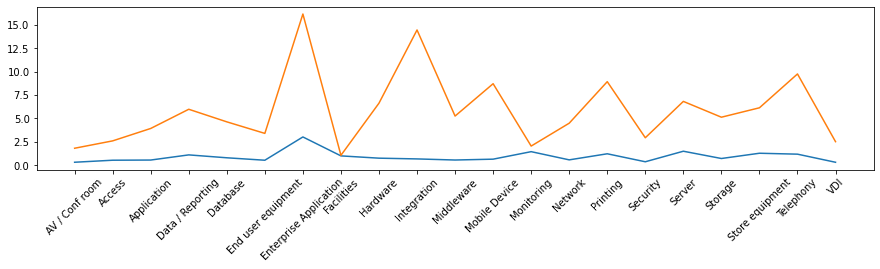

In [6]:
import time
import math
import numpy
import matplotlib.pyplot as plt
df_closed = df[df.state == 'Closed']
df_closed = df_closed[["sys_created_on",'resolved_at','calendar_duration','category','priority','reassignment_count']]
df_closed['time_spent'] = df_closed['calendar_duration']/(24*3600*2)
df_closed.groupby('category').agg(
    count=('time_spent', 'count'),
    reassign=('reassignment_count','mean'),
    max_duration=('time_spent', max),
    # Get min of the duration column for each group
    min_duration=('time_spent', min),
    # Get sum of the duration column for each group
    mean_duration=('time_spent', 'mean'),
)

df_reassign_timespent = df_closed.groupby(['category'])['reassignment_count','time_spent'].mean()
plt.figure(figsize=(15, 3))
plt.xticks(rotation = 45)
plt.plot(df_reassign_timespent)

In [7]:
df_reassign_timespent

,reassignment_count,time_spent
category,,
AV / Conf room,0.294815,1.792647
Access,0.511126,2.580189
Application,0.530500,3.908005
Data / Reporting,1.081633,5.960871
Database,0.772222,4.615749
End user equipment,0.510058,3.380408
Enterprise Application,3.000000,16.148364
Facilities,0.975238,1.037028
Hardware,0.730573,6.613721


In [ ]:
df_reassign_timespent = df_closed.groupby(['priority'])['time_spent'].mean()
df_reassign_timespent

priority
1 - Critical    0.977225
2 - High        5.885929
3 - Medium      8.596465
4 - Low         4.262509
5 - Very Low    4.827766
Name: time_spent, dtype: float64

In [ ]:
df_closed1 = df_closed[df_closed.priority == "1 - Critical"]
df_closed2 = df_closed[df_closed.priority == "2 - High"]
df_closed3 = df_closed[df_closed.priority == "3 - Medium"]
df_closed4 = df_closed[df_closed.priority == "4 - Low"]
df_closed5 = df_closed[df_closed.priority == "5 - Very Low"]

In [ ]:
data_1 = df_closed1.groupby(['category'])['reassignment_count','time_spent'].mean()
data_1.sort_values(by='time_spent',ascending=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,reassignment_count,time_spent
category,,
Telephony,1.954545,7.367306
Integration,1.750000,6.278950
Server,1.000000,3.544888
VDI,0.500000,3.166212
Database,0.000000,2.256343
Application,0.333333,1.818429
Printing,0.500000,1.584591
Network,0.148148,0.804281
Monitoring,0.666667,0.385185


In [ ]:
data_2 = df_closed2.groupby(['category'])['reassignment_count','time_spent'].mean()
data_2.sort_values(by='time_spent',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,reassignment_count,time_spent
category,,
Security,0.000000,24.604890
Telephony,3.534031,12.839742
Integration,1.954545,11.087750
Middleware,0.000000,10.435104
Printing,2.111111,9.583663
Server,1.657143,8.454361
Network,1.647059,8.317619
AV / Conf room,0.333333,7.783980
Hardware,1.839623,7.740646


In [ ]:
data_3 = df_closed3.groupby(['category'])['reassignment_count','time_spent'].mean()
data_3.sort_values(by='time_spent',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,reassignment_count,time_spent
category,,
Security,1.750000,24.171100
Enterprise Application,4.000000,18.186149
Mobile Device,1.343750,11.558647
Hardware,1.890977,9.605707
Telephony,1.524880,9.225639
Application,2.022693,9.088190
End user equipment,1.838710,8.648582
Store equipment,2.267857,8.313480
Data / Reporting,2.000000,8.048281


In [ ]:
data_4 = df_closed4.groupby(['category'])['reassignment_count','time_spent'].mean()
data_4.sort_values(by='time_spent',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,reassignment_count,time_spent
category,,
Integration,0.704698,12.710952
Enterprise Application,1.000000,12.072795
Middleware,0.333333,11.012706
Store equipment,1.687500,10.642537
Telephony,0.819381,9.884827
Printing,0.624009,9.087611
Data / Reporting,1.076923,7.496929
Hardware,1.075766,7.495142
Server,1.312500,6.376888


In [ ]:
data_5 = df_closed5.groupby(['category'])['reassignment_count','time_spent'].mean()
data_5.sort_values(by='time_spent',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,reassignment_count,time_spent
category,,
Integration,0.503096,15.349693
Telephony,0.711860,10.183610
Printing,1.258584,9.744862
Mobile Device,0.671419,9.538472
Monitoring,1.613636,8.578100
Server,1.304348,6.851020
Hardware,0.518181,6.133636
Store equipment,1.178691,5.731937
Data / Reporting,1.012500,5.661617


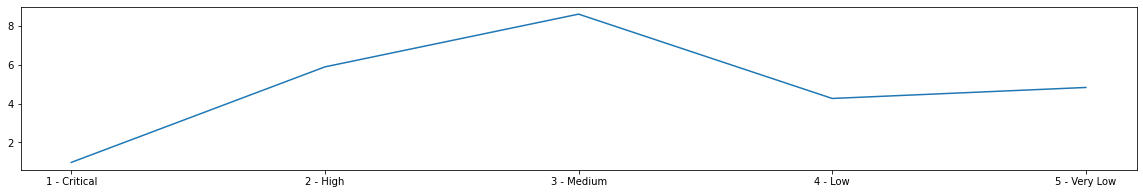

In [ ]:
plt.figure(figsize=(20, 3))

plt.plot(df_reassign_timespent)

['Application' 'Hardware' 'Access' 'VDI' 'Store equipment' 'Telephony'
 'End user equipment' 'Mobile Device' 'Printing' 'Integration'
 'Monitoring' 'Network' 'Database' 'Security' 'Storage' 'Data / Reporting'
 'Server' 'Facilities' 'AV / Conf room' 'Middleware'
 'Enterprise Application' nan]


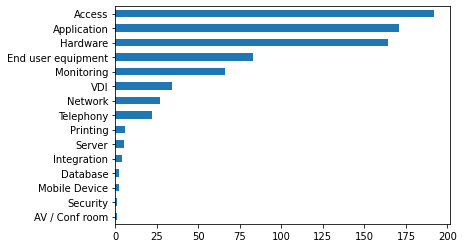

In [ ]:
catetories = df_closed.category.unique()
print(catetories)
#df_app = df_closed[df_closed.category == 'Application']
#df_app.priority.value_counts().sort_values().plot(kind = 'barh')
catlist = ['1 - Critical','2 - High', '3 - Medium']
catlist = ['1 - Critical']
df1 = df_closed[df_closed['priority'].isin(catlist)]
df1.category.value_counts().sort_values().plot(kind = 'barh')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/l

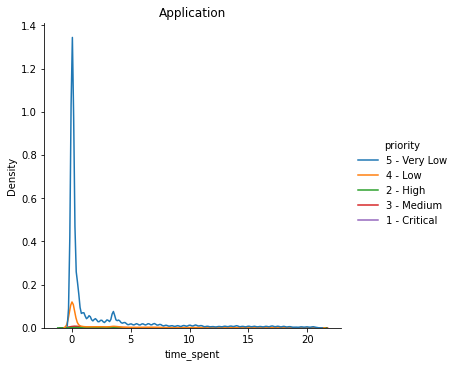

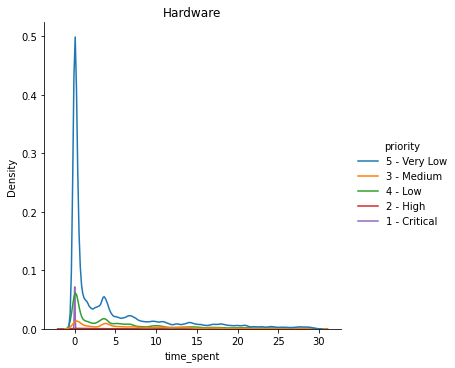

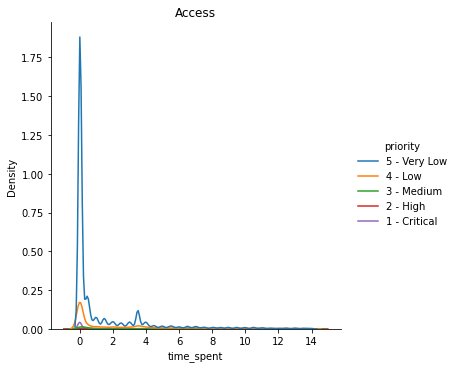

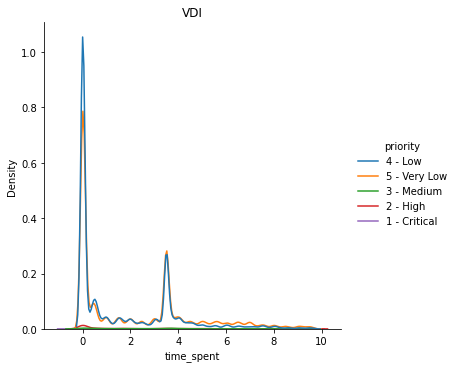

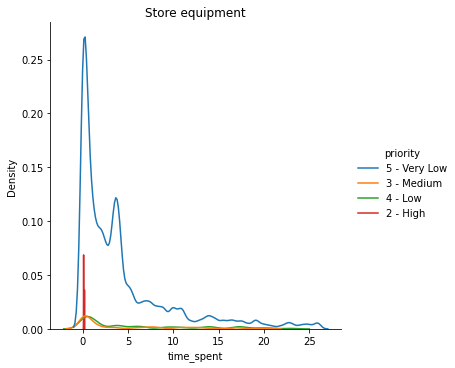

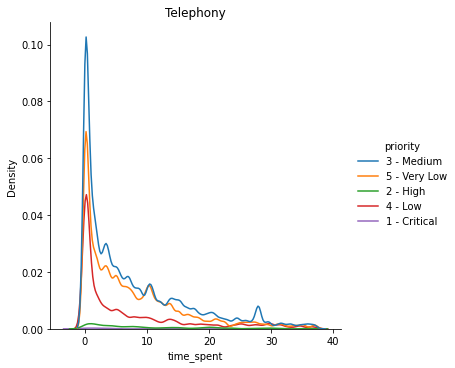

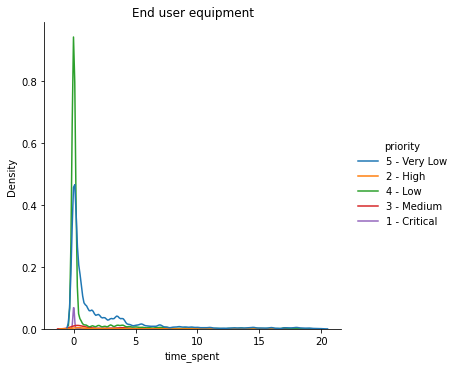

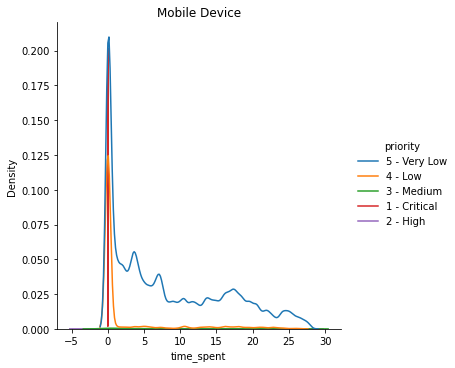

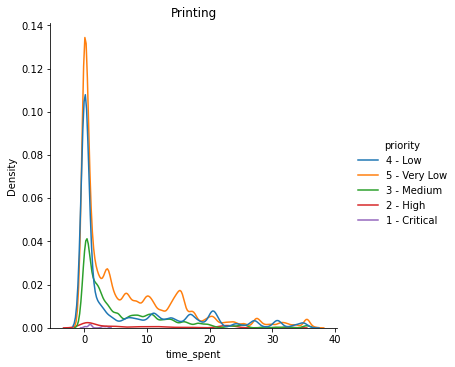

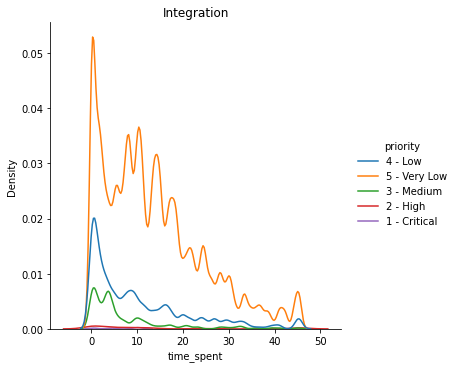

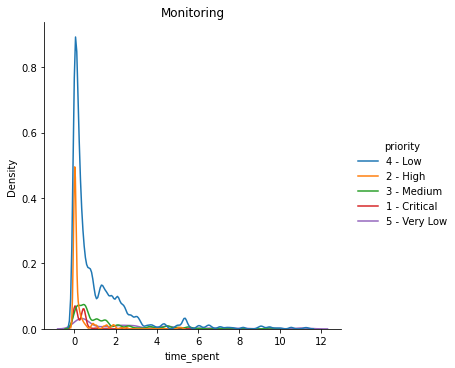

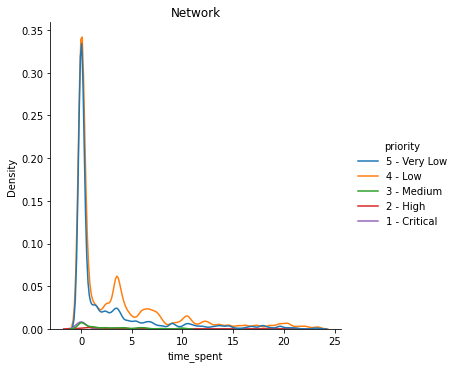

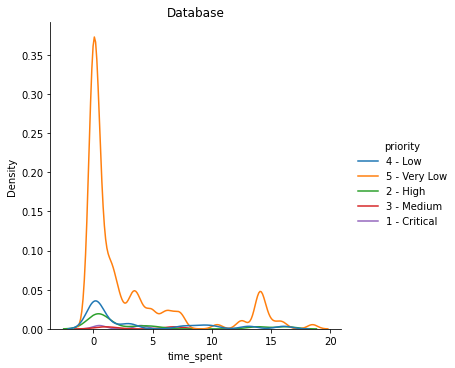

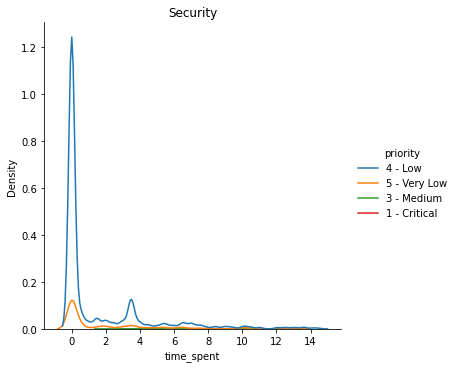

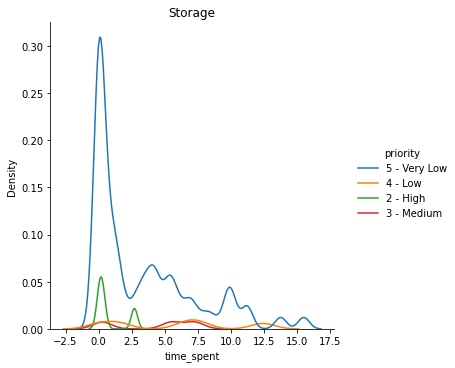

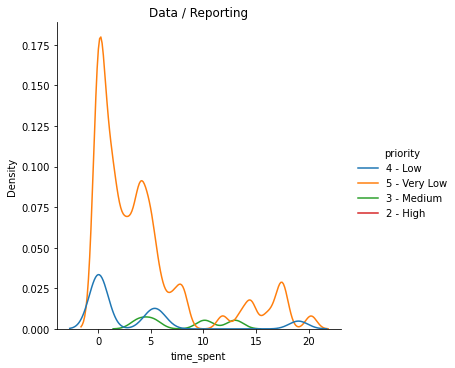

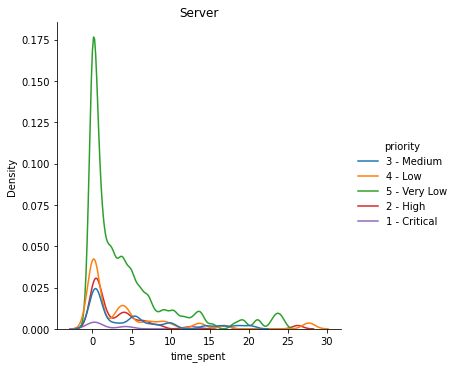

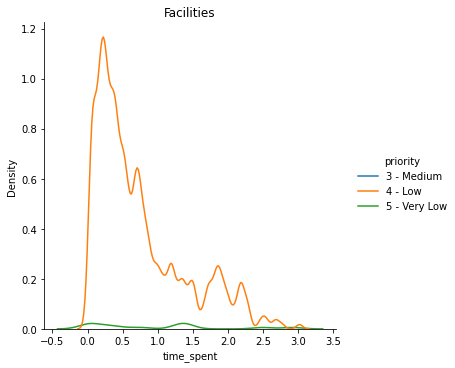

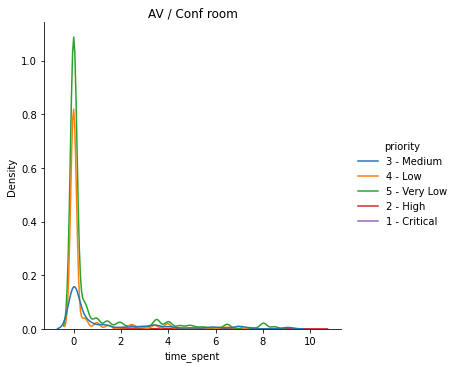

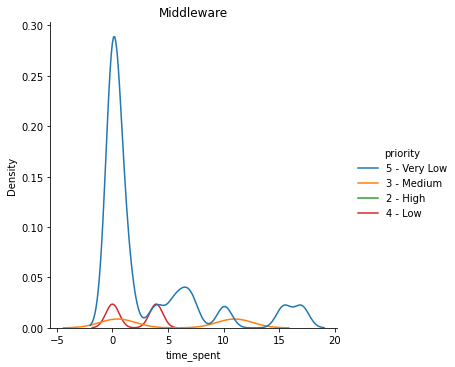

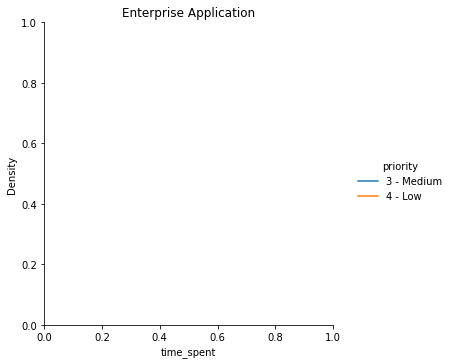

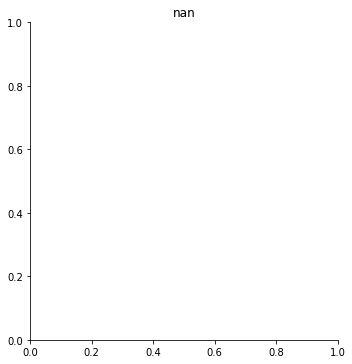

In [ ]:
#df_closed['time_spent'].hist(by=df_closed['category'])
import seaborn as sns
categories = df_closed.category.unique()
#df_time = df_closed['category','time_spent']

for i in categories:
  df_category = df_closed.loc[df_closed['category']==i]
  Q1 = df_category['time_spent'].quantile(0.95)
  sns.displot(df_closed.loc[df_closed['category'] == i][df_closed['time_spent']<Q1],x = 'time_spent',hue="priority",kind='kde',bw_adjust=.25).set(title = i)
